In [ ]:
%%javascript
function ClickConnect(){
  console.log("Keepalive connection clicked");
  document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000);

<IPython.core.display.Javascript object>

In [ ]:
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn tqdm gradio pillow

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
import requests
import tarfile
import datetime
import json
from tqdm import tqdm
import random
import warnings
import shutil
import io
from contextlib import redirect_stdout
import gradio as gr
from PIL import Image
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Check if GPU is available
print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"GPU is available: {physical_devices}")
    # Set memory growth to avoid OOM errors
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU is NOT available. Using CPU instead.")

TensorFlow version: 2.18.0
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Create a directory for data
data_dir = "stanford_dogs_dataset"
os.makedirs(data_dir, exist_ok=True)

# Define data paths
images_dir = os.path.join(data_dir, "Images")
annotations_dir = os.path.join(data_dir, "Annotation")

# Create directories for results
results_base_dir = "./Hybrid_CNN_Results"
os.makedirs(results_base_dir, exist_ok=True)

# Get timestamp for the experiment
experiment_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_dir = os.path.join(results_base_dir, f"experiment_{experiment_timestamp}")

# Create directories for results
os.makedirs(experiment_dir, exist_ok=True)
models_dir = os.path.join(experiment_dir, "models")
metrics_dir = os.path.join(experiment_dir, "metrics")
plots_dir = os.path.join(experiment_dir, "plots")
raw_data_dir = os.path.join(experiment_dir, "raw_data")
reports_dir = os.path.join(experiment_dir, "reports")
test_results_dir = os.path.join(experiment_dir, "test_results")

# Subdirectories
architectures_dir = os.path.join(models_dir, "architectures")
training_plots_dir = os.path.join(plots_dir, "training")
confusion_matrix_dir = os.path.join(plots_dir, "confusion_matrices")
comparison_dir = os.path.join(plots_dir, "comparisons")
examples_dir = os.path.join(plots_dir, "examples")

# Create all directories
for directory in [models_dir, metrics_dir, plots_dir, raw_data_dir, reports_dir,
                 architectures_dir, training_plots_dir, confusion_matrix_dir,
                 comparison_dir, examples_dir, test_results_dir]:
    os.makedirs(directory, exist_ok=True)

print(f"Results directory structure created at: {experiment_dir}")

# Global variables to store models, histories, and results
all_models = {}
all_histories = {}
all_results = {}
global_class_names = []

Results directory structure created at: ./Hybrid_CNN_Results/experiment_20250406_191525


In [ ]:
# Function to download and extract the dataset
def download_and_extract_dataset():
    # Define dataset URLs
    images_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
    annotations_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"

    # Download and extract images
    if not os.path.exists(images_dir):
        print("Downloading and extracting images...")

        # Try using wget if available (faster in Google Colab)
        try:
            import subprocess
            subprocess.run(["wget", "-O", os.path.join(data_dir, "images.tar"), images_url], check=True)
            subprocess.run(["tar", "-xf", os.path.join(data_dir, "images.tar"), "-C", data_dir], check=True)
            print("Images downloaded and extracted successfully.")
        except:
            # Fallback to requests if wget is not available
            print("Downloading images using requests (this may take a while)...")
            response = requests.get(images_url, stream=True)
            with open(os.path.join(data_dir, "images.tar"), "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            # Extract images
            print("Extracting images...")
            with tarfile.open(os.path.join(data_dir, "images.tar"), "r") as tar:
                tar.extractall(path=data_dir)
            print("Images extracted successfully.")
    else:
        print("Images directory already exists, skipping download.")

    # Download and extract annotations
    if not os.path.exists(annotations_dir):
        print("Downloading and extracting annotations...")

        # Try using wget if available
        try:
            import subprocess
            subprocess.run(["wget", "-O", os.path.join(data_dir, "annotation.tar"), annotations_url], check=True)
            subprocess.run(["tar", "-xf", os.path.join(data_dir, "annotation.tar"), "-C", data_dir], check=True)
            print("Annotations downloaded and extracted successfully.")
        except:
            # Fallback to requests
            print("Downloading annotations using requests...")
            response = requests.get(annotations_url, stream=True)
            with open(os.path.join(data_dir, "annotation.tar"), "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            # Extract annotations
            print("Extracting annotations...")
            with tarfile.open(os.path.join(data_dir, "annotation.tar"), "r") as tar:
                tar.extractall(path=data_dir)
            print("Annotations extracted successfully.")
    else:
        print("Annotations directory already exists, skipping download.")


In [ ]:
# Function to prepare data for training
def prepare_data(n_classes=10, samples_per_class=100, img_size=(224, 224), validation_split=0.15, test_split=0.15):
    global global_class_names

    # Check if images directory exists
    if not os.path.exists(images_dir):
        print("Images directory not found. Please download the dataset first.")
        return None, None, None, None, None

    # Get breed directories
    breed_dirs = sorted([d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))])

    # Limit classes if specified (currently disabled)
    # if n_classes > 0 and n_classes < len(breed_dirs):
    #     breed_dirs = breed_dirs[:n_classes]

    print(f"Using {len(breed_dirs)} classes (dog breeds)")

    # Create class mapping
    class_indices = {breed: idx for idx, breed in enumerate(breed_dirs)}
    class_names = breed_dirs
    global_class_names = class_names

    # Save class mapping to file
    class_mapping = {
        'class_names': class_names,
        'class_indices': class_indices
    }
    with open(os.path.join(raw_data_dir, "class_mapping.json"), 'w') as f:
        json.dump(class_mapping, f, indent=4)

    # Save a more readable version of class names
    readable_class_names = [name.replace('-', ' ').replace('_', ' ').title() for name in class_names]
    with open(os.path.join(raw_data_dir, "readable_class_names.json"), 'w') as f:
        json.dump(readable_class_names, f, indent=4)

    # Collect image paths and labels
    image_paths = []
    labels = []
    for breed_idx, breed in enumerate(tqdm(breed_dirs, desc="Processing breeds")):
        breed_dir = os.path.join(images_dir, breed)
        breed_images = [os.path.join(breed_dir, f) for f in os.listdir(breed_dir) if os.path.isfile(os.path.join(breed_dir, f))]
        # if samples_per_class > 0 and len(breed_images) > samples_per_class:
        #     random.shuffle(breed_images)
        #     breed_images = breed_images[:samples_per_class]
        image_paths.extend(breed_images)
        labels.extend([breed_idx] * len(breed_images))

    # Split data into train+val and test sets
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        image_paths, labels, test_size=validation_split + test_split,
        random_state=42, stratify=labels
    )
    relative_validation_size = validation_split / (validation_split + test_split)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=1 - relative_validation_size,
        random_state=42, stratify=temp_labels
    )

    # Create DataFrames with image paths and corresponding labels
    train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
    test_df = pd.DataFrame({'filename': test_paths, 'class': test_labels})

    # Convert class labels to actual class names (to preserve correct label mapping)
    train_df['class'] = train_df['class'].astype(int).apply(lambda x: class_names[x])
    val_df['class'] = val_df['class'].astype(int).apply(lambda x: class_names[x])
    test_df['class'] = test_df['class'].astype(int).apply(lambda x: class_names[x])

    train_datagen = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.3,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      rotation_range=30,
      horizontal_flip=True,
      fill_mode='nearest',
      brightness_range=[0.7, 1.3],  
      channel_shift_range=0.1    
    )

    # Only preprocess for validation and test (no augmentation)
    valid_test_datagen = ImageDataGenerator(
       rescale=1./255
    )

    # Create image data generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=32,
        class_mode='sparse',
        shuffle=True
    )
    validation_generator = valid_test_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=32,
        class_mode='sparse',
        shuffle=False
    )
    test_generator = valid_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=32,
        class_mode='sparse',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator, class_names, class_indices


In [ ]:
# Function to create baseline models
def create_baseline_model(model_name, num_classes, img_size=(224, 224)):
    input_shape = (*img_size, 3)

    # Create base model
    if model_name == 'mobilenetv2':
        base_model = applications.MobileNetV2(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
        preprocess_input = applications.mobilenet_v2.preprocess_input
        display_name = 'MobileNetV2'
    elif model_name == 'resnet50':
        base_model = applications.ResNet50(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
        preprocess_input = applications.resnet50.preprocess_input
        display_name = 'ResNet50'
    elif model_name == 'vgg16':
        base_model = applications.VGG16(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
        preprocess_input = applications.vgg16.preprocess_input
        display_name = 'VGG16'
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    # Freeze base model
    base_model.trainable = False

    # Create model
    inputs = layers.Input(shape=input_shape)

    # Pass through base model
    x = base_model(inputs, training=False)

    # Add classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name=display_name)

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for sparse class mode
        metrics=['accuracy']
    )

    # Save model architecture visualization
    try:
        arch_path = os.path.join(architectures_dir, f"{display_name}_architecture.png")
        plot_model(model, to_file=arch_path, show_shapes=True, show_layer_names=True, dpi=150)
        print(f"Model architecture visualization saved at {arch_path}")
    except Exception as e:
        print(f"Error saving model architecture: {e}")

    # Save model summary to file
    summary_path = os.path.join(architectures_dir, f"{display_name}_summary.txt")
    with open(summary_path, 'w') as f:
        with redirect_stdout(f):
            model.summary()
    print(f"Model summary saved at {summary_path}")

    return model, display_name

In [ ]:
def train_model(model, train_generator, validation_generator, epochs=30, model_name="model"):
    # Ensure model name doesn't already have extension
    if model_name.endswith('.keras') or model_name.endswith('.h5'):
        model_name = model_name.rsplit('.', 1)[0]

    # Create log directory
    log_dir = os.path.join(experiment_dir, "logs", model_name)
    os.makedirs(log_dir, exist_ok=True)

    # Define file paths with EXPLICIT extensions
    checkpoint_path = os.path.join(models_dir, f"{model_name}_best.keras")
    final_model_path = os.path.join(models_dir, f"{model_name}_final.keras")

    # Simple callbacks
    callbacks = [
        # Early stopping only
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        # TensorBoard logging
        TensorBoard(log_dir=log_dir)
    ]

    # Print key information
    print(f"Training {model_name}...")
    print(f"Model will be saved to: {final_model_path}")

    # Basic training with try-except
    try:
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=callbacks,
            verbose=1
        )

        # Save the model WITH proper extension
        print(f"Saving model to {final_model_path}")
        model.save(final_model_path)  # This will now have .keras extension
        print(f"Model saved successfully!")

        # Update global dictionaries
        all_models[model_name] = model
        all_histories[model_name] = history

        return model, history

    except Exception as e:
        print(f"Error during training: {e}")
        print("Attempting to save model anyway...")

        try:
            # Try to save the model anyway
            model.save(final_model_path)
            print(f"Model saved despite training error")
        except Exception as e2:
            print(f"Could not save model: {e2}")

        # Create minimal history object if training failed
        minimal_history = type('obj', (object,), {
            'history': {
                'accuracy': [],
                'val_accuracy': [],
                'loss': [],
                'val_loss': []
            }
        })

        all_models[model_name] = model
        all_histories[model_name] = minimal_history

        return model, minimal_history

In [ ]:

# Add these changes to your evaluate_model function
def evaluate_model(model, test_generator, class_names, model_name="model"):
    # Reset the generator to the beginning
    test_generator.reset()

    # Predict using the model
    start_time = time.time()
    y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
    end_time = time.time()

    # Calculate inference time
    inference_time = (end_time - start_time) / len(test_generator.filenames)

    # Get predicted classes
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true classes
    y_true = test_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Inference Time per Image: {inference_time*1000:.2f} ms")

    # Print classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred_classes, target_names=class_names)
    print(report)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    prediction_confidence = np.max(y_pred, axis=1)
    avg_confidence = np.mean(prediction_confidence)
    correct_mask = y_pred_classes == y_true
    avg_confidence_correct = np.mean(prediction_confidence[correct_mask])
    avg_confidence_incorrect = np.mean(prediction_confidence[~correct_mask])


    per_class_accuracy = {}
    for i, class_name in enumerate(class_names):
        class_mask = y_true == i
        if np.sum(class_mask) > 0:  # Avoid division by zero
            class_acc = accuracy_score(y_true[class_mask], y_pred_classes[class_mask])
            per_class_accuracy[class_name] = class_acc

    # Find worst performing classes
    worst_classes = sorted(per_class_accuracy.items(), key=lambda x: x[1])[:5]

    class_counts = np.bincount(y_true, minlength=len(class_names))

    y_true_np = np.array(y_true)
    y_pred_classes_np = np.array(y_pred_classes)
    prediction_confidence = np.max(y_pred, axis=1)


    # Add the new metrics to the results
    metrics = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'inference_time': float(inference_time),
        'inference_time_ms': float(inference_time * 1000)
    }

    # Save enhanced metrics
    metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)

    # Return all results including raw predictions for detailed analysis
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'inference_time': inference_time,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred_classes': y_pred_classes,
        'y_pred_prob': y_pred
    }

    # Update global results dictionary
    all_results[model_name] = results

    return results

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
# Function to compare models
def compare_models(results_dict, save_path=None):
    # Extract metrics
    models = list(results_dict.keys())
    accuracy = [results_dict[model]['accuracy'] for model in models]
    precision = [results_dict[model]['precision'] for model in models]
    recall = [results_dict[model]['recall'] for model in models]
    f1 = [results_dict[model]['f1'] for model in models]
    inference_time = [results_dict[model]['inference_time'] * 1000 for model in models]  # Convert to ms

    # Create DataFrame
    comparison_df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Inference Time (ms)': inference_time
    })

    # Print comparison
    print(comparison_df)

    # Save comparison to CSV
    if save_path is None:
        save_path = os.path.join(metrics_dir, "model_comparison.csv")

    comparison_df.to_csv(save_path, index=False)

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    ax = sns.barplot(x='Model', y='Accuracy', data=comparison_df)
    plt.title('Accuracy Comparison')
    # Add value labels on the bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.4f}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'bottom',
                  fontsize=10)

    # Plot precision
    plt.subplot(2, 2, 2)
    ax = sns.barplot(x='Model', y='Precision', data=comparison_df)
    plt.title('Precision Comparison')
    # Add value labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.4f}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'bottom',
                  fontsize=10)

    # Plot recall
    plt.subplot(2, 2, 3)
    ax = sns.barplot(x='Model', y='Recall', data=comparison_df)
    plt.title('Recall Comparison')
    # Add value labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.4f}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'bottom',
                  fontsize=10)

    # Plot F1 score
    plt.subplot(2, 2, 4)
    ax = sns.barplot(x='Model', y='F1 Score', data=comparison_df)
    plt.title('F1 Score Comparison')
    # Add value labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.4f}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'bottom',
                  fontsize=10)

    plt.tight_layout()

    # Save comparison plot
    comparison_plot_path = os.path.join(comparison_dir, "metrics_comparison.png")
    plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Plot inference time
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Model', y='Inference Time (ms)', data=comparison_df)
    plt.title('Inference Time Comparison')
    plt.ylabel('Time (ms)')

    # Add value labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.2f} ms',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'bottom',
                  fontsize=10)

    # Save inference time plot
    inference_plot_path = os.path.join(comparison_dir, "inference_time_comparison.png")
    plt.savefig(inference_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Generate a radar chart for comprehensive comparison
    try:
        # Normalize metrics for radar chart
        metrics_for_radar = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].copy()

        # Add normalized speed (inverse of inference time - higher is better)
        max_time = comparison_df['Inference Time (ms)'].max()

        # Number of metrics
        categories = metrics_for_radar.columns.tolist()
        N = len(categories)

        # Create angle for each metric
        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]  # Close the loop

        # Create radar chart
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

        # Add lines and points for each model
        for i, model in enumerate(comparison_df['Model']):
            values = metrics_for_radar.iloc[i].values.tolist()
            values += values[:1]  # Close the loop

            # Plot values
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
            ax.fill(angles, values, alpha=0.1)

        # Set labels
        plt.xticks(angles[:-1], categories)

        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.title("Model Performance Comparison", size=15)

        # Save radar chart
        radar_plot_path = os.path.join(comparison_dir, "radar_chart_comparison.png")
        plt.savefig(radar_plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error creating radar chart: {e}")

    # Create a summary table image
    try:
        # Format the table data with more precision
        formatted_df = comparison_df.copy()
        formatted_df['Accuracy'] = formatted_df['Accuracy'].map(lambda x: f"{x:.4f}")
        formatted_df['Precision'] = formatted_df['Precision'].map(lambda x: f"{x:.4f}")
        formatted_df['Recall'] = formatted_df['Recall'].map(lambda x: f"{x:.4f}")
        formatted_df['F1 Score'] = formatted_df['F1 Score'].map(lambda x: f"{x:.4f}")
        formatted_df['Inference Time (ms)'] = formatted_df['Inference Time (ms)'].map(lambda x: f"{x:.2f}")

        # Create a figure with just a table
        fig, ax = plt.subplots(figsize=(12, len(models) + 1))
        ax.axis('off')

        # Create the table
        table = ax.table(
            cellText=formatted_df.values,
            colLabels=formatted_df.columns,
            cellLoc='center',
            loc='center',
            bbox=[0, 0, 1, 1]
        )

        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)

        # Save the table as an image
        table_path = os.path.join(comparison_dir, "comparison_table.png")
        plt.savefig(table_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error creating comparison table image: {e}")

    return comparison_df


In [ ]:
# @title
def debug_prediction(model, image_path, class_names, actual_label=None, img_size=(224, 224)):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    import numpy as np
    import matplotlib.pyplot as plt

    # Load & preprocess image
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_batch = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_batch)
    top5_indices = np.argsort(preds[0])[::-1][:5]

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Prediction Input Image")
    plt.show()

    # Display top-5 predictions
    print("\n🔍 Top-5 Predictions:")
    for i in top5_indices:
        if i < len(class_names):
            print(f"Index {i}: {class_names[i]} — {preds[0][i]*100:.2f}%")
        else:
            print(f"Index {i}: Unknown class — {preds[0][i]*100:.2f}%")

    # Final prediction
    pred_index = np.argmax(preds[0])
    pred_class = class_names[pred_index] if pred_index < len(class_names) else "Unknown"

    print(f"\n Final Prediction → Index {pred_index}: {pred_class}")




In [ ]:
# Function to create a ZIP file of all results
def create_results_zip():
    """
    Create a ZIP file of all results

    Returns:
    - zip_path: Path to the created ZIP file
    """
    zip_path = f"{experiment_dir}.zip"
    shutil.make_archive(experiment_dir.rstrip('/'), 'zip', os.path.dirname(experiment_dir), os.path.basename(experiment_dir))

    print(f"Results ZIP file created at {zip_path}")

    # Try to download if in Colab
    try:
        from google.colab import files
        files.download(zip_path)
        print("ZIP file downloaded")
    except ImportError:
        print("Not running in Colab, ZIP file is available locally")

    return zip_path


In [ ]:
global all_models, all_histories, all_results, global_class_names

print("========== Starting Experiment ==========")

# Download and extract dataset if needed
download_and_extract_dataset()

# Prepare data
print("\n========== Preparing Data ==========")
train_generator, validation_generator, test_generator, class_names, class_indices = prepare_data(
    n_classes=10,  # Use 10 classes for faster training
    samples_per_class=100  # Use up to 100 samples per class
)

# Store class names globally
global_class_names = class_names

# Number of classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

========== Starting Experiment ==========
Images directory already exists, skipping download.
Annotations directory already exists, skipping download.

========== Preparing Data ==========
Using 120 classes (dog breeds)


Processing breeds: 100%|██████████| 120/120 [00:00<00:00, 463.47it/s]


Found 14406 validated image filenames belonging to 120 classes.
Found 3087 validated image filenames belonging to 120 classes.
Found 3087 validated image filenames belonging to 120 classes.
Number of classes: 120


In [ ]:
# @title
# Train and evaluate baseline MobileNetV2 model
print("\n========== Training MobileNetV2 Baseline Model ==========")
mobilenetv2_model, mobilenetv2_name = create_baseline_model('mobilenetv2', num_classes)
mobilenetv2_model, mobilenetv2_history = train_model(
    mobilenetv2_model,
    train_generator,
    validation_generator,
    epochs=10,
    model_name=mobilenetv2_name
)


========== Training MobileNetV2 Baseline Model ==========


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,621,880 (10.00 MB)

 Trainable params: 361,336 (1.38 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

Model architecture visualization saved at ./Hybrid_CNN_Results/experiment_20250406_191525/models/architectures/MobileNetV2_architecture.png
Model summary saved at ./Hybrid_CNN_Results/experiment_20250406_191525/models/architectures/MobileNetV2_summary.txt
Training MobileNetV2...
Model will be saved to: ./Hybrid_CNN_Results/experiment_20250406_191525/models/MobileNetV2_final.keras
Epoch 1/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 299s 607ms/step - accuracy: 0.2179 - loss: 3.6748 - val_accuracy: 0.6916 - val_loss: 1.0427
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 299s 582ms/step - accuracy: 0.4592 - loss: 2.0818 - val_accuracy: 0.7191 - val_loss: 0.9203
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 264s 584ms/step - accuracy: 0.5011 - loss: 1.8969 - val_accuracy: 0.7337 - val_loss: 0.8815
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 263s 583ms/step - accuracy: 0.5197 - loss: 1.7411 - val_accuracy: 0.7373 - val_loss: 0.8611
Epoch 5/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 264s 586ms/step - accuracy: 0.5393 - loss: 1.6994

In [ ]:
# @title
# Evaluate model
print(f"\n========== Evaluating {mobilenetv2_name} Baseline Model ==========")
mobilenetv2_results = evaluate_model(mobilenetv2_model, test_generator, class_names, mobilenetv2_name)


========== Evaluating MobileNetV2 Baseline Model ==========
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step
Accuracy: 0.7279
Precision: 0.7407
Recall: 0.7279
F1 Score: 0.7237
Average Inference Time per Image: 5.97 ms

Classification Report:
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.40      0.43      0.42        23
              n02085782-Japanese_spaniel       0.92      0.86      0.89        28
                   n02085936-Maltese_dog       0.89      0.84      0.86        38
                      n02086079-Pekinese       0.90      0.82      0.86        22
                      n02086240-Shih-Tzu       0.53      0.66      0.58        32
              n02086646-Blenheim_spaniel       1.00      0.75      0.86        28
                      n02086910-papillon       0.81      0.83      0.82        30
                   n02087046-toy_terrier       0.91      0.38      0.54        26
           n02087394-Rhod

In [ ]:
# @title
# Train and evaluate baseline ResNet50 model
print("\n========== Training ResNet50 Baseline Model ==========")
resnet50_model, resnet50_name = create_baseline_model('resnet50', num_classes)
resnet50_model, resnet50_history = train_model(
    resnet50_model,
    train_generator,
    validation_generator,
    epochs=10,
    model_name=resnet50_name
)


========== Training ResNet50 Baseline Model ==========
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,151,288 (92.13 MB)

 Trainable params: 559,480 (2.13 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Model architecture visualization saved at ./Hybrid_CNN_Results/experiment_20250406_191525/models/architectures/ResNet50_architecture.png
Model summary saved at ./Hybrid_CNN_Results/experiment_20250406_191525/models/architectures/ResNet50_summary.txt
Training ResNet50...
Model will be saved to: ./Hybrid_CNN_Results/experiment_20250406_191525/models/ResNet50_final.keras
Epoch 1/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 302s 634ms/step - accuracy: 0.0108 - loss: 4.8909 - val_accuracy: 0.0123 - val_loss: 4.7789
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 276s 613ms/step - accuracy: 0.0156 - loss: 4.7688 - val_accuracy: 0.0236 - val_loss: 4.7203
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 276s 612ms/step - accuracy: 0.0151 - loss: 4.7548 - val_accuracy: 0.0227 - val_loss: 4.6759
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 273s 606ms/step - accuracy: 0.0176 - loss: 4.7296 - val_accuracy: 0.0285 - val_loss: 4.6682
Epoch 5/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 272s 604ms/step - accuracy: 0.0192 - loss: 4.7185 - val_accur

In [ ]:
# @title
# Evaluate model
print(f"\n========== Evaluating {resnet50_name} Baseline Model ==========")
resnet50_results = evaluate_model(resnet50_model, test_generator, class_names, resnet50_name)




========== Evaluating ResNet50 Baseline Model ==========
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step
Accuracy: 0.0327
Precision: 0.0143
Recall: 0.0327
F1 Score: 0.0124
Average Inference Time per Image: 6.69 ms

Classification Report:
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.00      0.00      0.00        23
              n02085782-Japanese_spaniel       0.09      0.32      0.14        28
                   n02085936-Maltese_dog       0.07      0.34      0.12        38
                      n02086079-Pekinese       0.00      0.00      0.00        22
                      n02086240-Shih-Tzu       0.07      0.19      0.10        32
              n02086646-Blenheim_spaniel       0.00      0.00      0.00        28
                      n02086910-papillon       0.00      0.00      0.00        30
                   n02087046-toy_terrier       0.00      0.00      0.00        26
           n02087394-Rhodesi

In [ ]:
# @title
# Train and evaluate baseline VGG16 model
print("\n========== Training VGG16 Baseline Model ==========")
vgg16_model, vgg16_name = create_baseline_model('vgg16', num_classes)
vgg16_model, vgg16_history = train_model(
    vgg16_model,
    train_generator,
    validation_generator,
    epochs=10,
    model_name=vgg16_name
)



========== Training VGG16 Baseline Model ==========
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,878,904 (56.76 MB)

 Trainable params: 163,192 (637.47 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

Model architecture visualization saved at ./Hybrid_CNN_Results/experiment_20250406_191525/models/architectures/VGG16_architecture.png
Model summary saved at ./Hybrid_CNN_Results/experiment_20250406_191525/models/architectures/VGG16_summary.txt
Training VGG16...
Model will be saved to: ./Hybrid_CNN_Results/experiment_20250406_191525/models/VGG16_final.keras
Epoch 1/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 315s 668ms/step - accuracy: 0.0253 - loss: 4.9300 - val_accuracy: 0.1377 - val_loss: 3.9573
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 291s 645ms/step - accuracy: 0.0926 - loss: 4.0879 - val_accuracy: 0.1953 - val_loss: 3.2935
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 296s 656ms/step - accuracy: 0.1431 - loss: 3.7696 - val_accuracy: 0.2417 - val_loss: 3.0762
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 288s 637ms/step - accuracy: 0.1609 - loss: 3.5763 - val_accuracy: 0.2579 - val_loss: 2.9703
Epoch 5/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 289s 640ms/step - accuracy: 0.1720 - loss: 3.5117 - val_accuracy: 0.2705 

In [ ]:
# @title
 # Evaluate model
print(f"\n========== Evaluating {vgg16_name} Baseline Model ==========")
vgg16_results = evaluate_model(vgg16_model, test_generator, class_names, vgg16_name)


========== Evaluating VGG16 Baseline Model ==========
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step
Accuracy: 0.3016
Precision: 0.3112
Recall: 0.3016
F1 Score: 0.2865
Average Inference Time per Image: 5.90 ms

Classification Report:
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.25      0.04      0.07        23
              n02085782-Japanese_spaniel       0.50      0.54      0.52        28
                   n02085936-Maltese_dog       0.55      0.45      0.49        38
                      n02086079-Pekinese       0.09      0.05      0.06        22
                      n02086240-Shih-Tzu       0.19      0.16      0.17        32
              n02086646-Blenheim_spaniel       0.42      0.64      0.51        28
                      n02086910-papillon       0.44      0.50      0.47        30
                   n02087046-toy_terrier       0.24      0.15      0.19        26
           n02087394-Rhodesian_


========== Comparing Pre-trained Models ==========
         Model  Accuracy  Precision    Recall  F1 Score  Inference Time (ms)
0  MobileNetV2  0.727891   0.740680  0.727891  0.723729             5.969090
1     ResNet50  0.032718   0.014337  0.032718  0.012414             6.686029
2        VGG16  0.301587   0.311191  0.301587  0.286503             5.904231


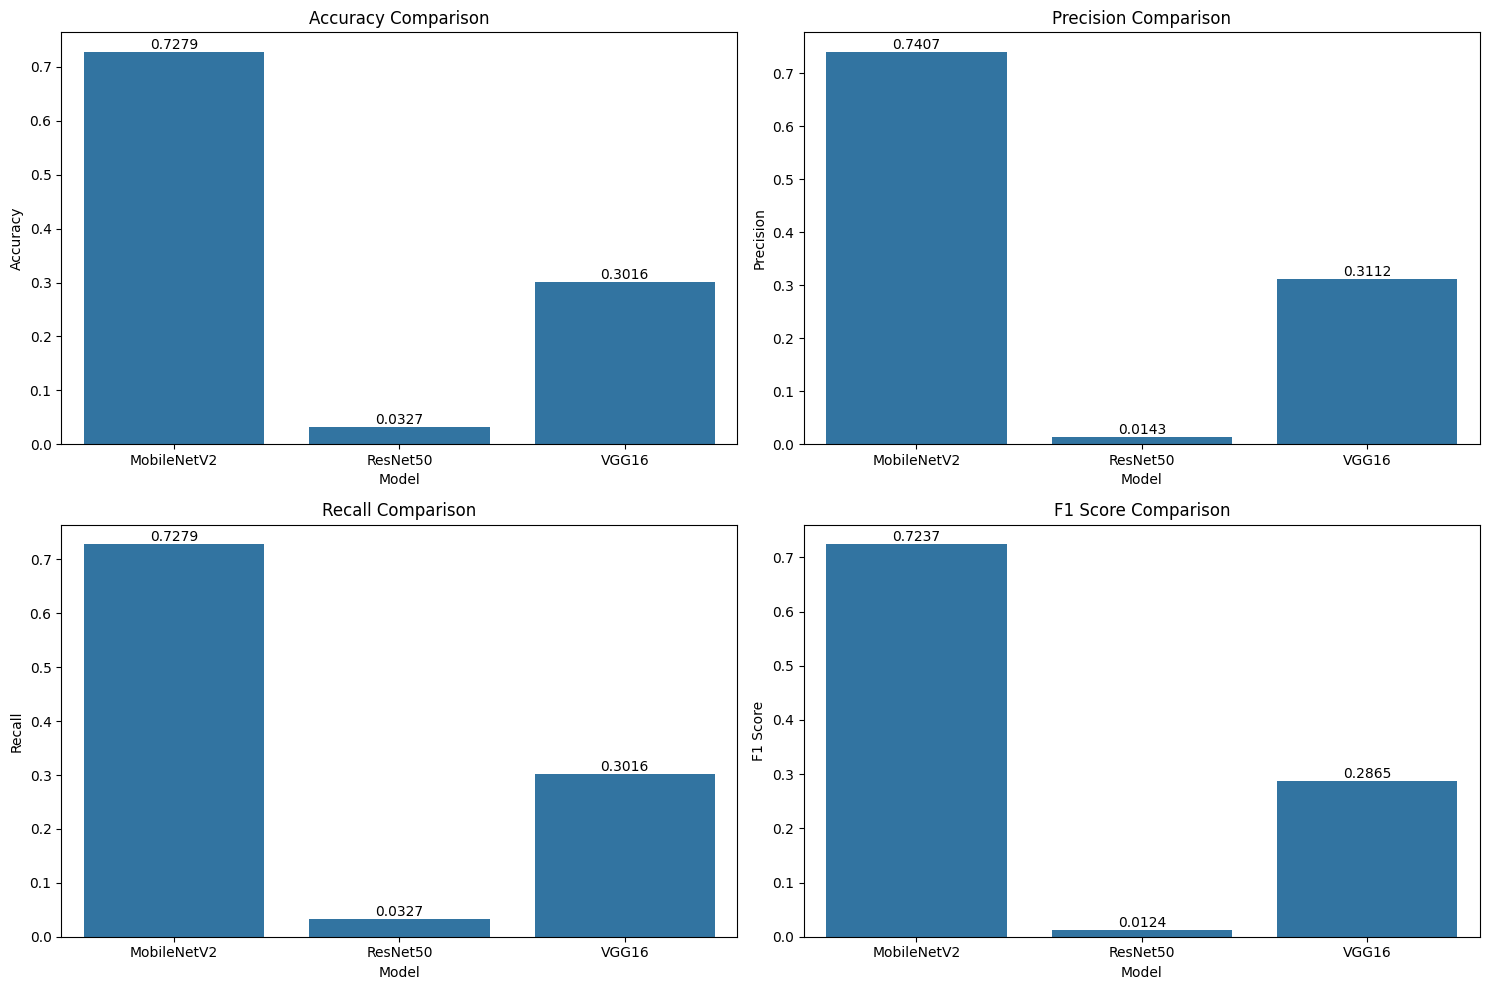

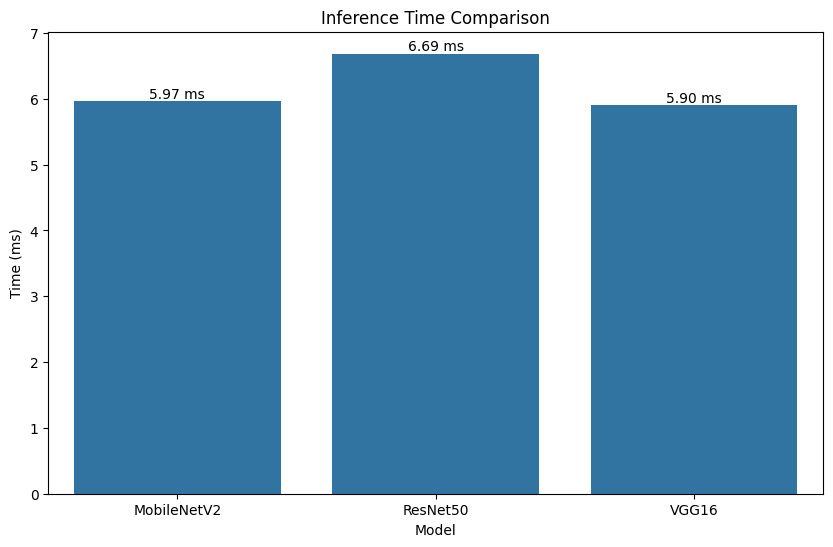

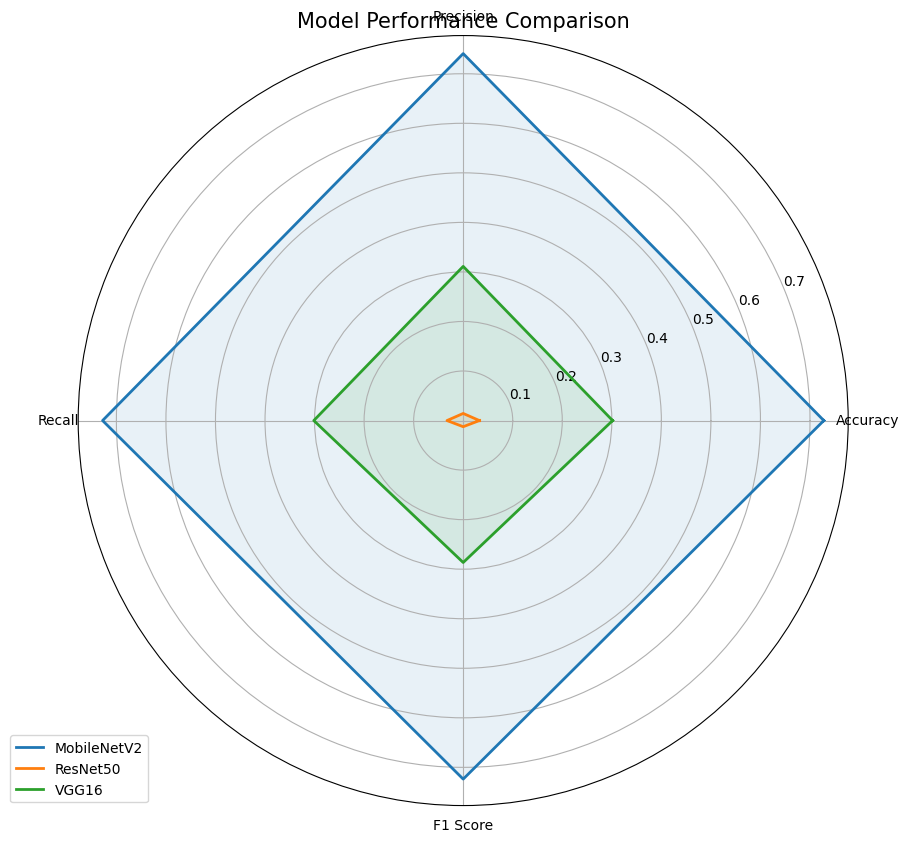

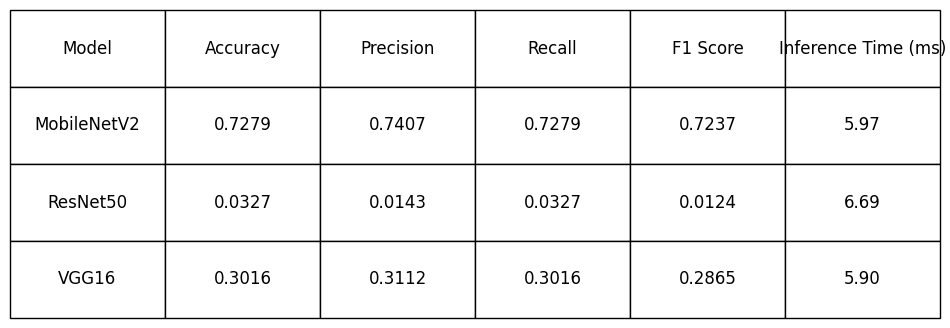

In [ ]:
# @title
# Compare models
print("\n========== Comparing Pre-trained Models ==========")
comparison_df = compare_models(all_results)

In [ ]:
# Function to create an hybrid model with multi-head attention
def create_hybrid_model(num_classes, img_size=(224, 224)):
    input_shape = (*img_size, 3)
    input_layer = layers.Input(shape=input_shape)

    # Helper function to build each branch of the model
    def build_branch(base_model_class):
        base_model = base_model_class(include_top=False, weights='imagenet', input_tensor=input_layer)
        base_model.trainable = False  # Initially freeze
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Reshape((1, 512))(x)
        return x

    def reduce_mean_axis1(x):
      return tf.reduce_mean(x, axis=1)

    # Build three branches
    branch1 = build_branch(applications.MobileNetV2)
    branch2 = build_branch(applications.ResNet50)
    branch3 = build_branch(applications.VGG16)

    # Concatenate features along sequence dimension
    feature_seq = layers.Concatenate(axis=1)([branch1, branch2, branch3])  # (batch, 3, 512)

    # Apply multi-head attention
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=512)(feature_seq, feature_seq)
    x = layers.Add()([feature_seq, attention_output])
    x = layers.LayerNormalization()(x)
    # x = tf.reduce_mean(x, axis=1)  # Average over sequence dimension
    x = layers.Lambda(reduce_mean_axis1, name='reduce_mean_axis1')(x)  # Correct approach

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output, name="Hybrid")

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Save model architecture visualization
    try:
        arch_path = os.path.join(architectures_dir, "Hybrid_architecture.png")
        plot_model(model, to_file=arch_path, show_shapes=True, show_layer_names=True, dpi=150)
        print(f"Model architecture visualization saved at {arch_path}")
    except Exception as e:
        print(f"Error saving model architecture: {e}")

    # Save model summary to file
    summary_path = os.path.join(architectures_dir, "Hybrid_summary.txt")
    with open(summary_path, 'w') as f:
        with redirect_stdout(f):
            model.summary()
            for i, layer in enumerate(model.layers):
              print(f"Layer {i}: {layer.name}")
              print(f"  Type: {layer.__class__.__name__}")
              print(f"  Trainable: {layer.trainable}")
              print(f"  Parameters: {layer.count_params()}")
              print()
    print(f"Model summary saved at {summary_path}")

    return model, "Hybrid"

In [ ]:
# @title
# Train and evaluate the advanced hybrid model
print("\n========== Training Advanced Hybrid Model ==========")
hybrid_model, hybrid_name = create_hybrid_model(num_classes)
hybrid_model, hybrid_history = train_model(
    hybrid_model,
    train_generator,
    validation_generator,
    epochs=30,  # Train longer for this complex model
    model_name=hybrid_name
)


========== Training Advanced Hybrid Model ==========


Model: "Hybrid"

"dot" with args ['-Tpng', '/tmp/tmpg_z9fjcm/tmpk6fine18'] returned code: -6

stdout, stderr:
 b''
b"failed at node 11203[0]\ndot: maze.c:311: chkSgraph: Assertion `np->cells[0]' failed.\n"

Error saving model architecture: "dot" with args ['-Tpng', '/tmp/tmpg_z9fjcm/tmpk6fine18'] returned code: -6


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 46,808,952 (178.56 MB)

 Trainable params: 6,239,864 (23.80 MB)

 Non-trainable params: 40,569,088 (154.76 MB)

Model summary saved at ./Hybrid_CNN_Results/experiment_20250406_191525/models/architectures/Hybrid_summary.txt
Training Hybrid...
Model will be saved to: ./Hybrid_CNN_Results/experiment_20250406_191525/models/Hybrid_final.keras
Epoch 1/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 391s 795ms/step - accuracy: 0.2486 - loss: 3.5904 - val_accuracy: 0.6712 - val_loss: 1.0798
Epoch 2/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 344s 764ms/step - accuracy: 0.4543 - loss: 2.0845 - val_accuracy: 0.7055 - val_loss: 0.9858
Epoch 3/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 333s 738ms/step - accuracy: 0.4808 - loss: 1.9314 - val_accuracy: 0.7010 - val_loss: 0.9703
Epoch 4/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 330s 730ms/step - accuracy: 0.5100 - loss: 1.7882 - val_accuracy: 0.7149 - val_loss: 0.9402
Epoch 5/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 382s 732ms/step - accuracy: 0.5337 - loss: 1.6975 - val_accuracy: 0.7166 - val_loss: 0.9326
Epoch 6/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 328s 728ms/step - accuracy: 0.5443 - loss: 1.6116 - val_accuracy: 0.7266

In [ ]:
# Evaluate model
print(f"\n========== Evaluating {hybrid_name} Model ==========")
hybrid_results = evaluate_model(hybrid_model, test_generator, class_names, hybrid_name)


========== Evaluating Hybrid Model ==========
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 362ms/step
Accuracy: 0.7402
Precision: 0.7582
Recall: 0.7402
F1 Score: 0.7404
Average Inference Time per Image: 14.61 ms

Classification Report:
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.47      0.65      0.55        23
              n02085782-Japanese_spaniel       0.96      0.82      0.88        28
                   n02085936-Maltese_dog       0.77      0.87      0.81        38
                      n02086079-Pekinese       0.86      0.86      0.86        22
                      n02086240-Shih-Tzu       0.58      0.69      0.63        32
              n02086646-Blenheim_spaniel       0.95      0.75      0.84        28
                      n02086910-papillon       0.88      0.93      0.90        30
                   n02087046-toy_terrier       0.80      0.46      0.59        26
           n02087394-Rhodesian_ridgeba

In [ ]:
# @title
# Add the optimized model to the results for comparison
all_results[f"{hybrid_name}"] = hybrid_results

In [ ]:
# @title
def fine_tune_hybrid_model(num_classes, img_size=(224, 224)):
    input_shape = (*img_size, 3)
    input_layer = layers.Input(shape=input_shape)

    # Helper function to build each branch
    def build_branch(base_model_class):
        base_model = base_model_class(include_top=False, weights='imagenet', input_tensor=input_layer)
        base_model.trainable = False  # Freeze base model

        if 'MobileNetV2' in str(base_model_class):
          for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers
            layer.trainable = True
        elif 'ResNet' in str(base_model_class):
          for layer in base_model.layers[-15:]:  # Unfreeze last 15 layers
            layer.trainable = True

        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(256, activation='relu')(x)  # Reduced from 512
        x = layers.Dropout(0.3)(x)
        x = layers.Reshape((1, 256))(x)
        return x

    def reduce_mean_axis1(x):
        return tf.reduce_mean(x, axis=1)

    # Use only two branches for speed
    branch1 = build_branch(applications.MobileNetV2)
    branch2 = build_branch(applications.ResNet50)

    # Concatenate features along sequence dimension → (batch, 2, 256)
    feature_seq = layers.Concatenate(axis=1)([branch1, branch2])

    # Apply multi-head attention (2 heads, lighter)
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=256)(feature_seq, feature_seq)
    x = layers.Add()([feature_seq, attention_output])  # Residual connection
    x = layers.LayerNormalization()(x)

    x = layers.Lambda(reduce_mean_axis1, name='reduce_mean_axis1')(x)  # Global average

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes,
                     activation='softmax',
                     kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

    model = models.Model(inputs=input_layer, outputs=output, name="FTHybrid")

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Fine Tuned Hybrid Model compiled.")
    return model, "FTHybrid"


In [ ]:
# Train and evaluate the advanced hybrid model
print("\n========== Training Advanced Hybrid Model ==========")
ft_hybrid_model, ft_hybrid_name = fine_tune_hybrid_model(num_classes)
ft_hybrid_model, ft_hybrid_history = train_model(
    ft_hybrid_model,
    train_generator,
    validation_generator,
    epochs=40,  # Train longer for this complex model
    model_name=ft_hybrid_name
)



========== Training Advanced Hybrid Model ==========
Fine Tuned Hybrid Model compiled.
Training FTHybrid...
Model will be saved to: ./Hybrid_CNN_Results/experiment_20250406_191525/models/FTHybrid_final.keras
Epoch 1/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 347s 686ms/step - accuracy: 0.0791 - loss: 4.6796 - val_accuracy: 0.5614 - val_loss: 1.6824
Epoch 2/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 280s 620ms/step - accuracy: 0.3719 - loss: 2.5217 - val_accuracy: 0.6560 - val_loss: 1.2580
Epoch 3/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 283s 627ms/step - accuracy: 0.4508 - loss: 2.0904 - val_accuracy: 0.6796 - val_loss: 1.1266
Epoch 4/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 285s 632ms/step - accuracy: 0.4969 - loss: 1.8962 - val_accuracy: 0.7094 - val_loss: 1.0249
Epoch 5/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 326s 640ms/step - accuracy: 0.5199 - loss: 1.7924 - val_accuracy: 0.7195 - val_loss: 0.9731
Epoch 6/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 299s 662ms/step - accuracy: 0.5403 - loss: 1.7014 - val_accuracy: 0.7224 - val_loss: 0.9698

In [ ]:
# Evaluate model
print(f"\n========== Evaluating {ft_hybrid_name} Model ==========")
ft_hybrid_results = evaluate_model(ft_hybrid_model, test_generator, class_names, ft_hybrid_name)


========== Evaluating FTHybrid Model ==========
97/97 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step
Accuracy: 0.7263
Precision: 0.7472
Recall: 0.7263
F1 Score: 0.7230
Average Inference Time per Image: 9.38 ms

Classification Report:
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.60      0.52      0.56        23
              n02085782-Japanese_spaniel       1.00      0.82      0.90        28
                   n02085936-Maltese_dog       0.83      0.79      0.81        38
                      n02086079-Pekinese       0.72      0.82      0.77        22
                      n02086240-Shih-Tzu       0.44      0.78      0.56        32
              n02086646-Blenheim_spaniel       0.93      0.89      0.91        28
                      n02086910-papillon       0.81      1.00      0.90        30
                   n02087046-toy_terrier       0.92      0.42      0.58        26
           n02087394-Rhodesian_ridgeb

In [ ]:
# @title
# Add the optimized model to the results for comparison
all_results[f"{ft_hybrid_name}"] = ft_hybrid_results


========== Comparing Hybrid Models ==========
         Model  Accuracy  Precision    Recall  F1 Score  Inference Time (ms)
0  MobileNetV2  0.727891   0.740680  0.727891  0.723729             5.969090
1     ResNet50  0.032718   0.014337  0.032718  0.012414             6.686029
2        VGG16  0.301587   0.311191  0.301587  0.286503             5.904231
3       Hybrid  0.740201   0.758232  0.740201  0.740367            14.613321
4     FTHybrid  0.726271   0.747162  0.726271  0.723039             9.375581


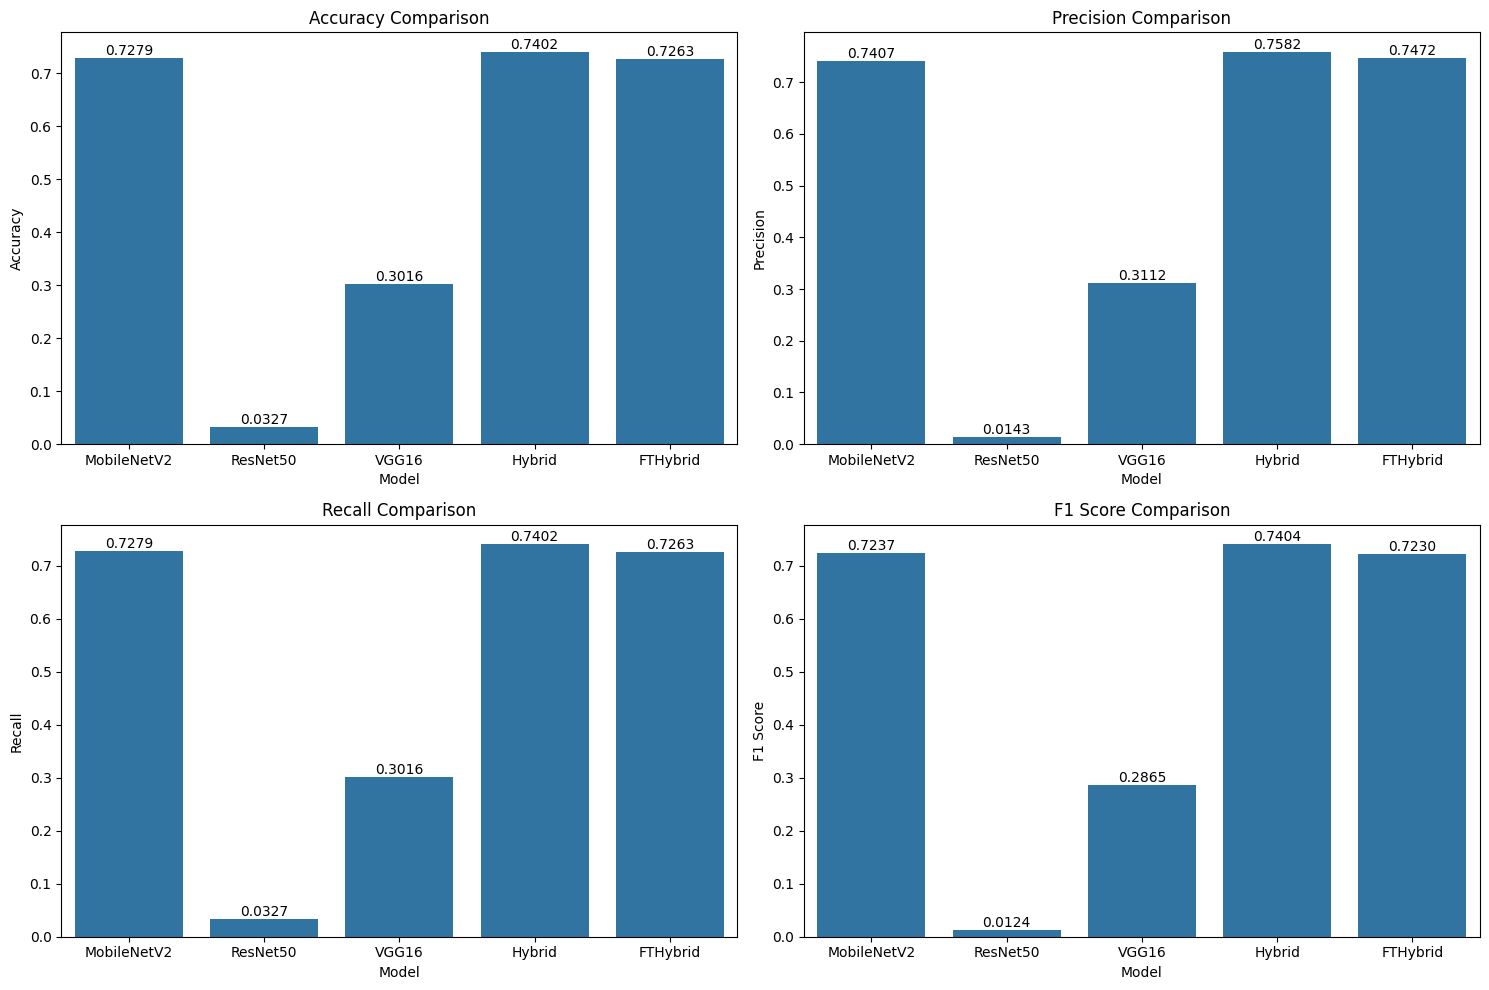

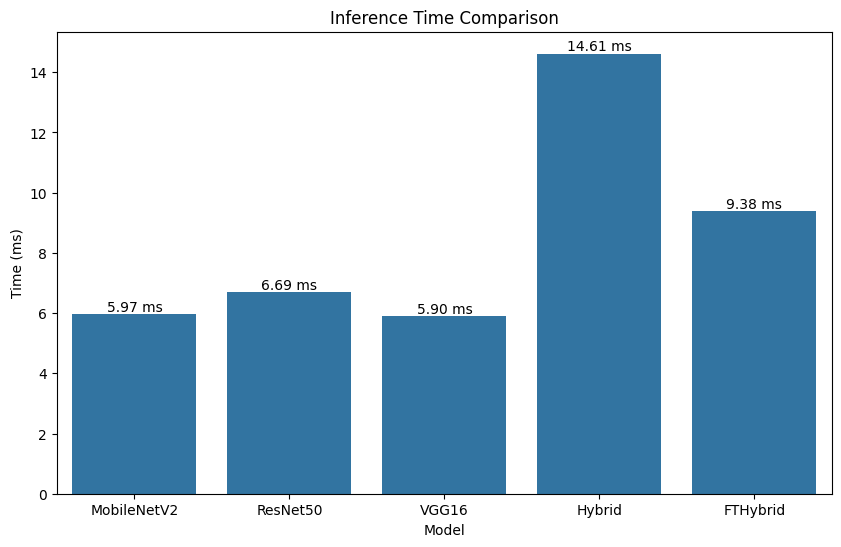

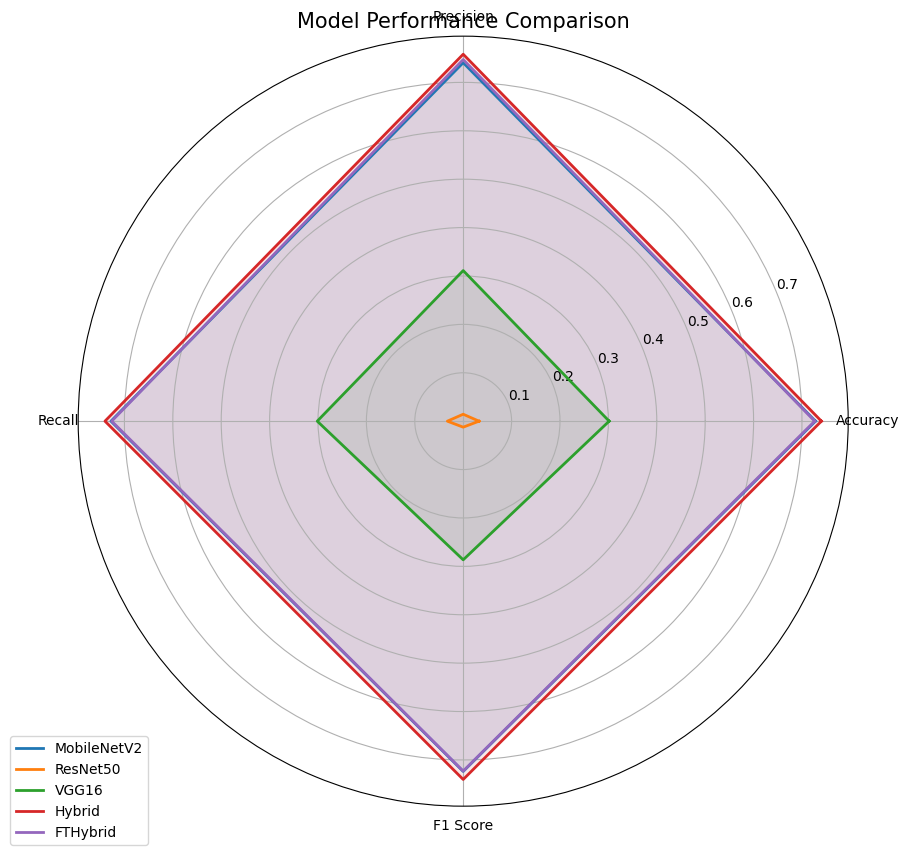

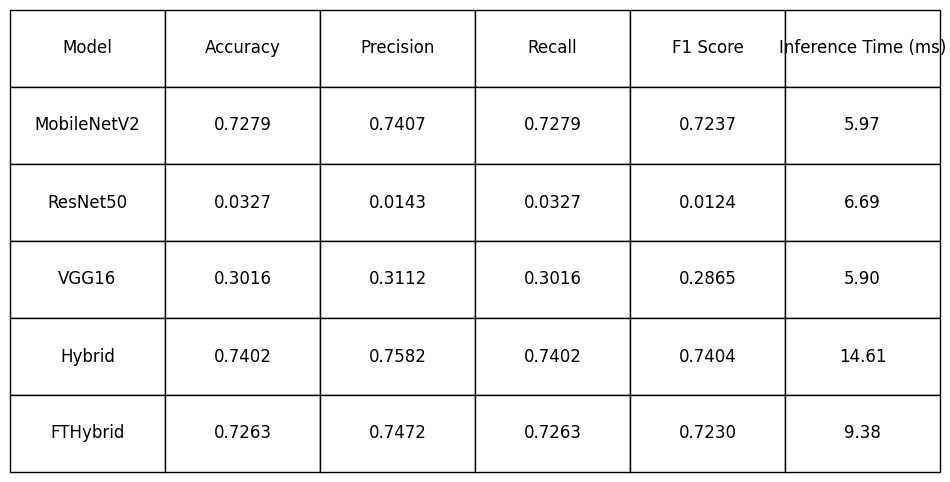

In [ ]:
# @title
# Compare models
print("\n========== Comparing Hybrid Models ==========")
Hybrid_comparison_df = compare_models(all_results)

In [ ]:
# Create ZIP file of all results
print("\n========== Creating Results ZIP ==========")
zip_path = create_results_zip()

print("\n========== Experiment Complete ==========")
print(f"All results are saved in: {experiment_dir}")
print(f"Results ZIP file: {zip_path}")


========== Creating Results ZIP ==========
Results ZIP file created at ./Hybrid_CNN_Results/experiment_20250406_191525.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ZIP file downloaded

========== Experiment Complete ==========
All results are saved in: ./Hybrid_CNN_Results/experiment_20250406_191525
Results ZIP file: ./Hybrid_CNN_Results/experiment_20250406_191525.zip


In [ ]:
# @title
# Load correct class names by index from class_mapping.json
import json

with open("/content/Hybrid_CNN_Results/experiment_20250402_231619/raw_data/class_mapping.json") as f:
    class_map = json.load(f)

# Reverse the class_indices dict: index → class name
index_to_label = {v: k for k, v in class_map['class_indices'].items()}

# Create list of readable class names (for predictions)
verified_class_names1 = [index_to_label[i] for i in range(len(index_to_label))]

print("✅ Label mapping verified and loaded.")
print(verified_class_names1)


In [ ]:
# debug_prediction(faster_hybrid_model2, '/content/Miniature_pinscher.jpg', verified_class_names1, actual_label="'Index 86: n02107312-miniature_pinscher'")
# debug_prediction(faster_hybrid_model2, '/content/n02085936_10610.jpg', verified_class_names1, actual_label="'Index 2: n02085936-Maltese_dog'")
# debug_prediction(faster_hybrid_model2, '/content/n02086240_1016.jpg', verified_class_names1, actual_label="'Index 4: n02086240-Shih-Tzu'")
# debug_prediction(faster_hybrid_model2, '/content/n02087394_1336.jpg', verified_class_names1, actual_label="'Index 8: n02087394-Rhodesian_ridgeback'")
# debug_prediction(faster_hybrid_model2, '/content/n02090721_1003.jpg', verified_class_names1, actual_label="'Index 19: n02090721-Irish_wolfhound'")
# debug_prediction(faster_hybrid_model2, '/content/Pirate Black Bart- 3 months_1.JPG', verified_class_names1, actual_label="'Pirate Black'")
# debug_prediction(faster_hybrid_model2, '/content/English_Toy_Terriers_Face.jpg', verified_class_names1, actual_label="'Index 7: n02087046-toy_terrier'")
# debug_prediction(faster_hybrid_model2, '/content/dobberman.jpg', verified_class_names1, actual_label="'dobberman'")
# debug_prediction(faster_hybrid_model2, '/content/American_Staffordshire_terrier.jpeg', verified_class_names1, actual_label="'American_Staffordshire_terrier'")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


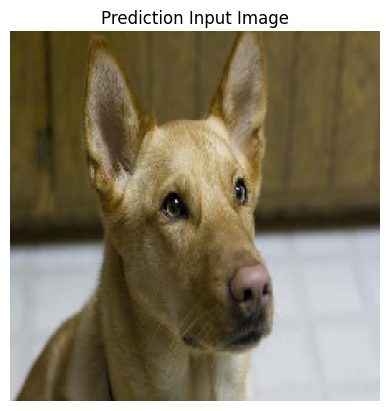


🔍 Top-5 Predictions:
Index 76: n02105412-kelpie — 82.01%
Index 117: n02115641-dingo — 10.08%
Index 74: n02105162-malinois — 4.81%
Index 22: n02091244-Ibizan_hound — 1.68%
Index 84: n02106662-German_shepherd — 0.48%

 Final Prediction → Index 76: n02105412-kelpie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


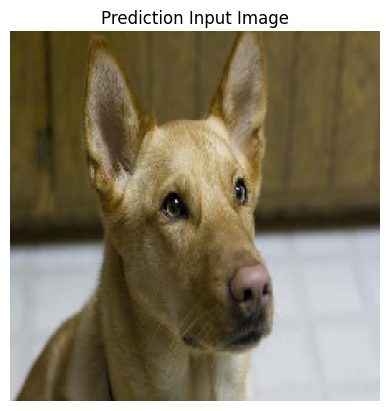


🔍 Top-5 Predictions:
Index 76: n02105412-kelpie — 57.37%
Index 117: n02115641-dingo — 26.50%
Index 74: n02105162-malinois — 13.30%
Index 118: n02115913-dhole — 0.82%
Index 101: n02110806-basenji — 0.63%

 Final Prediction → Index 76: n02105412-kelpie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


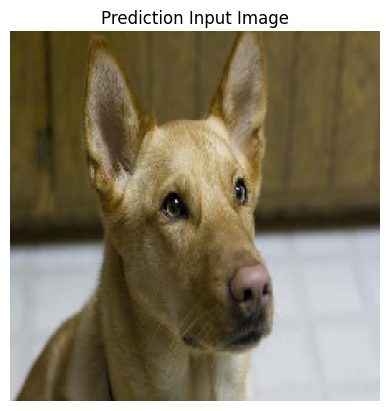


🔍 Top-5 Predictions:
Index 117: n02115641-dingo — 58.37%
Index 76: n02105412-kelpie — 27.96%
Index 74: n02105162-malinois — 4.48%
Index 22: n02091244-Ibizan_hound — 2.46%
Index 84: n02106662-German_shepherd — 0.91%

 Final Prediction → Index 117: n02115641-dingo


'n02115641-dingo'

In [ ]:
debug_prediction(mobilenetv2_model, '/content/stanford_dogs_dataset/Images/n02115641-dingo/n02115641_12836.jpg', verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(hybrid_model, '/content/stanford_dogs_dataset/Images/n02115641-dingo/n02115641_12836.jpg', verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(ft_hybrid_model, '/content/stanford_dogs_dataset/Images/n02115641-dingo/n02115641_12836.jpg', verified_class_names1, actual_label="n02115641-dingo")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


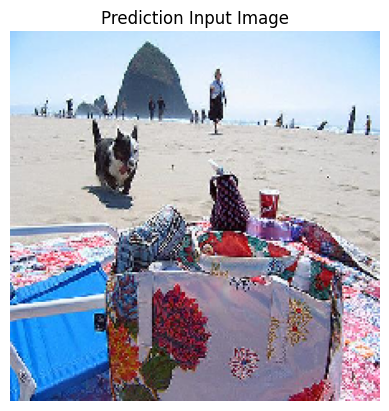


🔍 Top-5 Predictions:
Index 102: n02110958-pug — 36.43%
Index 13: n02088632-bluetick — 11.54%
Index 10: n02088238-basset — 4.10%
Index 61: n02100735-English_setter — 4.03%
Index 44: n02096585-Boston_bull — 2.65%

 Final Prediction → Index 102: n02110958-pug
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


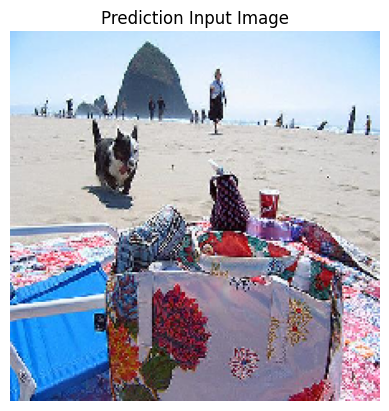


🔍 Top-5 Predictions:
Index 26: n02092002-Scottish_deerhound — 8.07%
Index 24: n02091635-otterhound — 6.67%
Index 99: n02110185-Siberian_husky — 5.79%
Index 98: n02110063-malamute — 5.06%
Index 45: n02097047-miniature_schnauzer — 3.51%

 Final Prediction → Index 26: n02092002-Scottish_deerhound
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


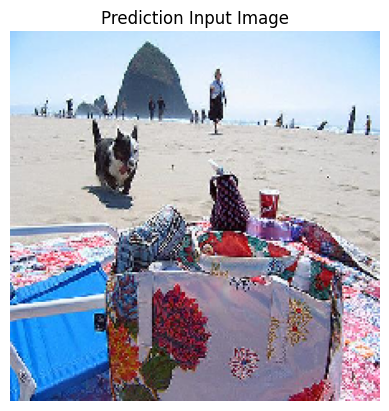


🔍 Top-5 Predictions:
Index 112: n02113186-Cardigan — 46.83%
Index 96: n02109525-Saint_Bernard — 4.09%
Index 9: n02088094-Afghan_hound — 3.49%
Index 61: n02100735-English_setter — 3.35%
Index 66: n02102040-English_springer — 3.19%

 Final Prediction → Index 112: n02113186-Cardigan


'n02113186-Cardigan'

In [ ]:
debug_prediction(mobilenetv2_model, '/content/stanford_dogs_dataset/Images/n02113186-Cardigan/n02113186_10519.jpg', verified_class_names1, actual_label="n02113186-Cardigan")
debug_prediction(hybrid_model, '/content/stanford_dogs_dataset/Images/n02113186-Cardigan/n02113186_10519.jpg', verified_class_names1, actual_label="n02113186-Cardigan")
debug_prediction(ft_hybrid_model, '/content/stanford_dogs_dataset/Images/n02113186-Cardigan/n02113186_10519.jpg', verified_class_names1, actual_label="n02113186-Cardigan")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


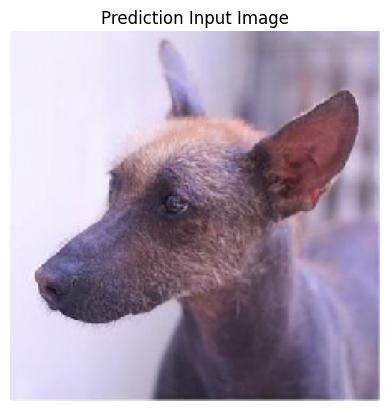


🔍 Top-5 Predictions:
Index 76: n02105412-kelpie — 90.71%
Index 116: n02113978-Mexican_hairless — 2.41%
Index 117: n02115641-dingo — 1.34%
Index 74: n02105162-malinois — 1.09%
Index 7: n02087046-toy_terrier — 0.83%

 Final Prediction → Index 76: n02105412-kelpie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


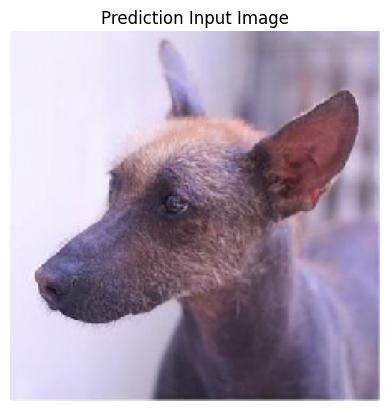


🔍 Top-5 Predictions:
Index 76: n02105412-kelpie — 80.92%
Index 74: n02105162-malinois — 6.97%
Index 117: n02115641-dingo — 3.87%
Index 101: n02110806-basenji — 2.23%
Index 86: n02107312-miniature_pinscher — 2.12%

 Final Prediction → Index 76: n02105412-kelpie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


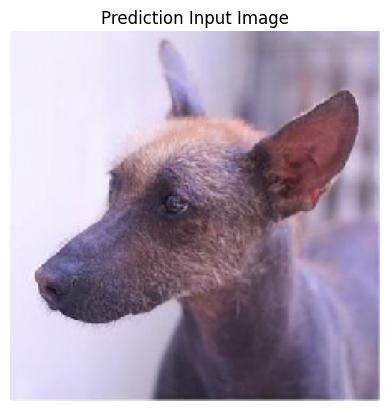


🔍 Top-5 Predictions:
Index 116: n02113978-Mexican_hairless — 85.29%
Index 74: n02105162-malinois — 5.17%
Index 76: n02105412-kelpie — 2.31%
Index 22: n02091244-Ibizan_hound — 1.14%
Index 85: n02107142-Doberman — 1.09%

 Final Prediction → Index 116: n02113978-Mexican_hairless


'n02113978-Mexican_hairless'

In [ ]:
debug_prediction(mobilenetv2_model, '/content/stanford_dogs_dataset/Images/n02113978-Mexican_hairless/n02113978_1069.jpg', verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(hybrid_model, '/content/stanford_dogs_dataset/Images/n02113978-Mexican_hairless/n02113978_1069.jpg', verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(ft_hybrid_model, '/content/stanford_dogs_dataset/Images/n02113978-Mexican_hairless/n02113978_1069.jpg', verified_class_names1, actual_label="n02115641-dingo")


In [ ]:
image_path = '/content/stanford_dogs_dataset/Images/n02105641-Old_English_sheepdog/n02105641_10264.jpg'
# image_name = image_path.split('/')[-1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


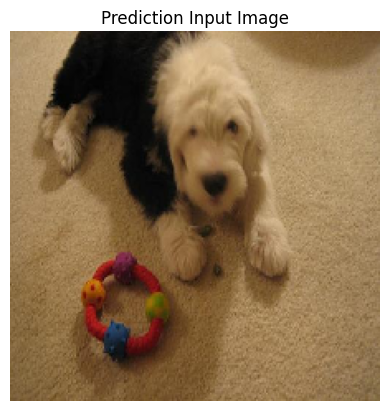


🔍 Top-5 Predictions:
Index 49: n02097474-Tibetan_terrier — 51.60%
Index 78: n02105641-Old_English_sheepdog — 25.77%
Index 43: n02096437-Dandie_Dinmont — 13.06%
Index 2: n02085936-Maltese_dog — 2.63%
Index 4: n02086240-Shih-Tzu — 2.08%

 Final Prediction → Index 49: n02097474-Tibetan_terrier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


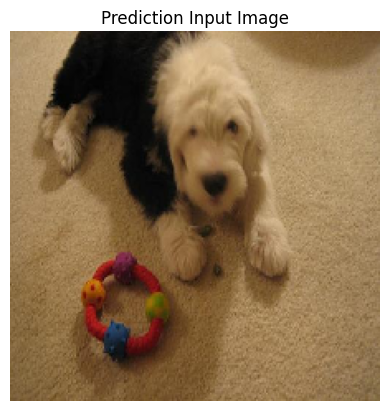


🔍 Top-5 Predictions:
Index 78: n02105641-Old_English_sheepdog — 65.26%
Index 43: n02096437-Dandie_Dinmont — 18.51%
Index 49: n02097474-Tibetan_terrier — 8.11%
Index 4: n02086240-Shih-Tzu — 3.32%
Index 39: n02095889-Sealyham_terrier — 1.99%

 Final Prediction → Index 78: n02105641-Old_English_sheepdog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


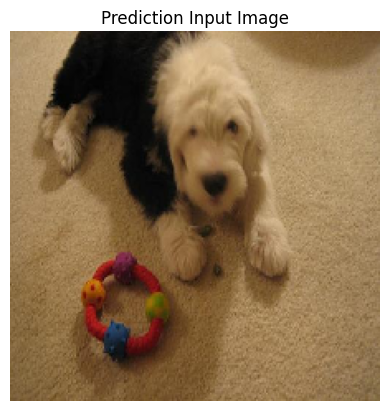


🔍 Top-5 Predictions:
Index 78: n02105641-Old_English_sheepdog — 57.42%
Index 43: n02096437-Dandie_Dinmont — 25.59%
Index 2: n02085936-Maltese_dog — 6.18%
Index 49: n02097474-Tibetan_terrier — 4.14%
Index 52: n02098286-West_Highland_white_terrier — 2.06%

 Final Prediction → Index 78: n02105641-Old_English_sheepdog


'n02105641-Old_English_sheepdog'

In [ ]:
debug_prediction(mobilenetv2_model, image_path, verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(hybrid_model, image_path, verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(ft_hybrid_model, image_path, verified_class_names1, actual_label="n02115641-dingo")


In [ ]:
image_path1 = '/content/stanford_dogs_dataset/Images/n02105412-kelpie/n02105412_1201.jpg'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


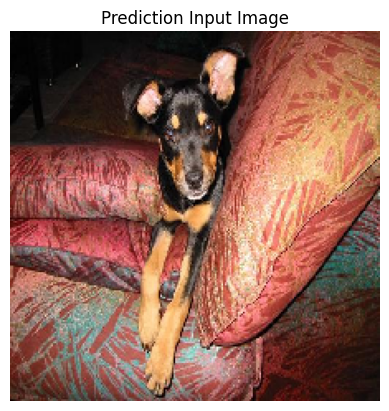


🔍 Top-5 Predictions:
Index 86: n02107312-miniature_pinscher — 43.43%
Index 76: n02105412-kelpie — 42.20%
Index 85: n02107142-Doberman — 9.52%
Index 83: n02106550-Rottweiler — 2.07%
Index 7: n02087046-toy_terrier — 0.96%

 Final Prediction → Index 86: n02107312-miniature_pinscher
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


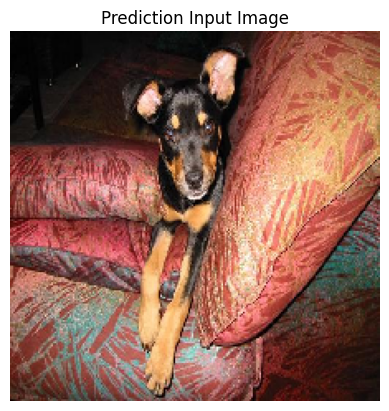


🔍 Top-5 Predictions:
Index 86: n02107312-miniature_pinscher — 52.86%
Index 76: n02105412-kelpie — 43.08%
Index 7: n02087046-toy_terrier — 1.14%
Index 83: n02106550-Rottweiler — 0.70%
Index 85: n02107142-Doberman — 0.51%

 Final Prediction → Index 86: n02107312-miniature_pinscher
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


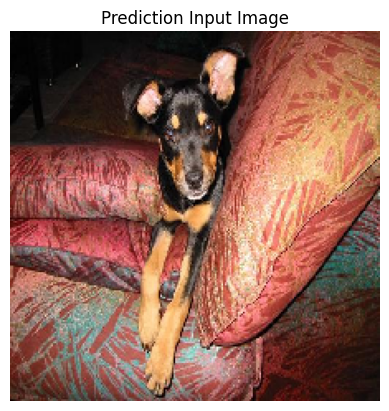


🔍 Top-5 Predictions:
Index 76: n02105412-kelpie — 34.73%
Index 86: n02107312-miniature_pinscher — 27.90%
Index 83: n02106550-Rottweiler — 18.08%
Index 7: n02087046-toy_terrier — 8.48%
Index 85: n02107142-Doberman — 2.38%

 Final Prediction → Index 76: n02105412-kelpie


'n02105412-kelpie'

In [ ]:
debug_prediction(mobilenetv2_model, image_path1, verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(hybrid_model, image_path1, verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(ft_hybrid_model, image_path1, verified_class_names1, actual_label="n02115641-dingo")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


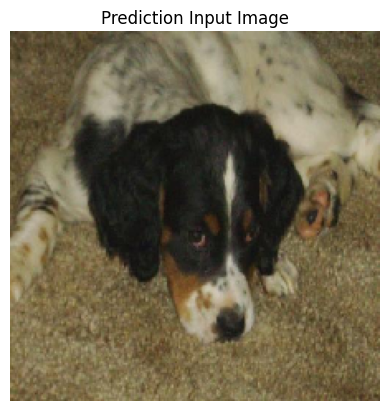


🔍 Top-5 Predictions:
Index 88: n02107683-Bernese_mountain_dog — 78.99%
Index 66: n02102040-English_springer — 7.80%
Index 90: n02108000-EntleBucher — 5.61%
Index 61: n02100735-English_setter — 3.31%
Index 89: n02107908-Appenzeller — 2.40%

 Final Prediction → Index 88: n02107683-Bernese_mountain_dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


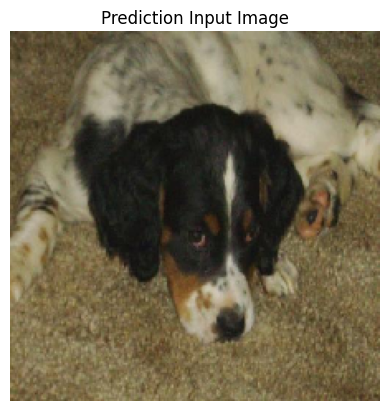


🔍 Top-5 Predictions:
Index 61: n02100735-English_setter — 62.53%
Index 88: n02107683-Bernese_mountain_dog — 21.76%
Index 81: n02106166-Border_collie — 6.54%
Index 64: n02101388-Brittany_spaniel — 1.43%
Index 49: n02097474-Tibetan_terrier — 1.11%

 Final Prediction → Index 61: n02100735-English_setter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


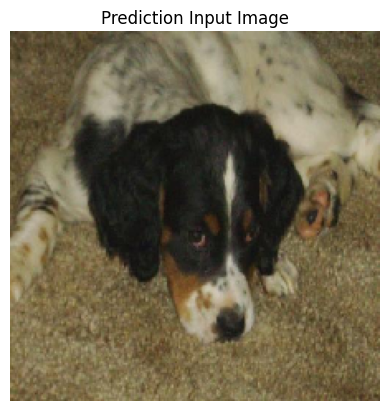


🔍 Top-5 Predictions:
Index 61: n02100735-English_setter — 80.63%
Index 88: n02107683-Bernese_mountain_dog — 12.95%
Index 65: n02101556-clumber — 1.12%
Index 66: n02102040-English_springer — 0.94%
Index 64: n02101388-Brittany_spaniel — 0.58%

 Final Prediction → Index 61: n02100735-English_setter


'n02100735-English_setter'

In [ ]:
image_path2 = '/content/stanford_dogs_dataset/Images/n02100735-English_setter/n02100735_10114.jpg'

debug_prediction(mobilenetv2_model, image_path2, verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(hybrid_model, image_path2, verified_class_names1, actual_label="n02115641-dingo")
debug_prediction(ft_hybrid_model, image_path2, verified_class_names1, actual_label="n02115641-dingo")

In [ ]:
def plot_training_history(history, model_name):
    """Plots the training and validation accuracy and loss curves."""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')

    plt.tight_layout()
    plot_path = os.path.join(training_plots_dir, f"{model_name}_training_plot.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

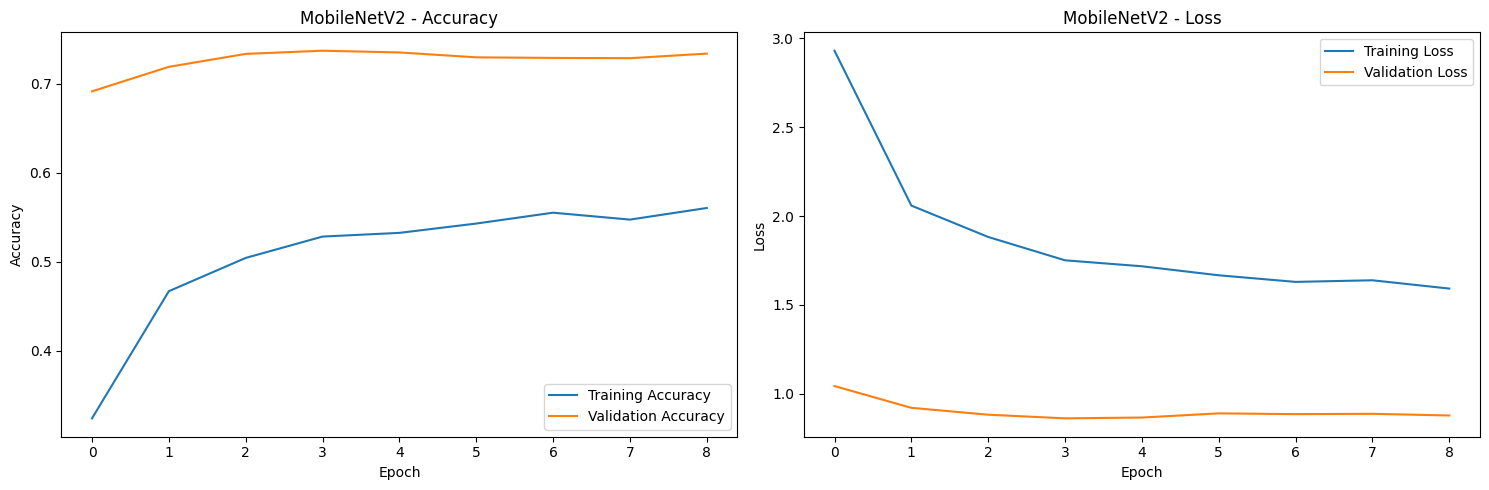

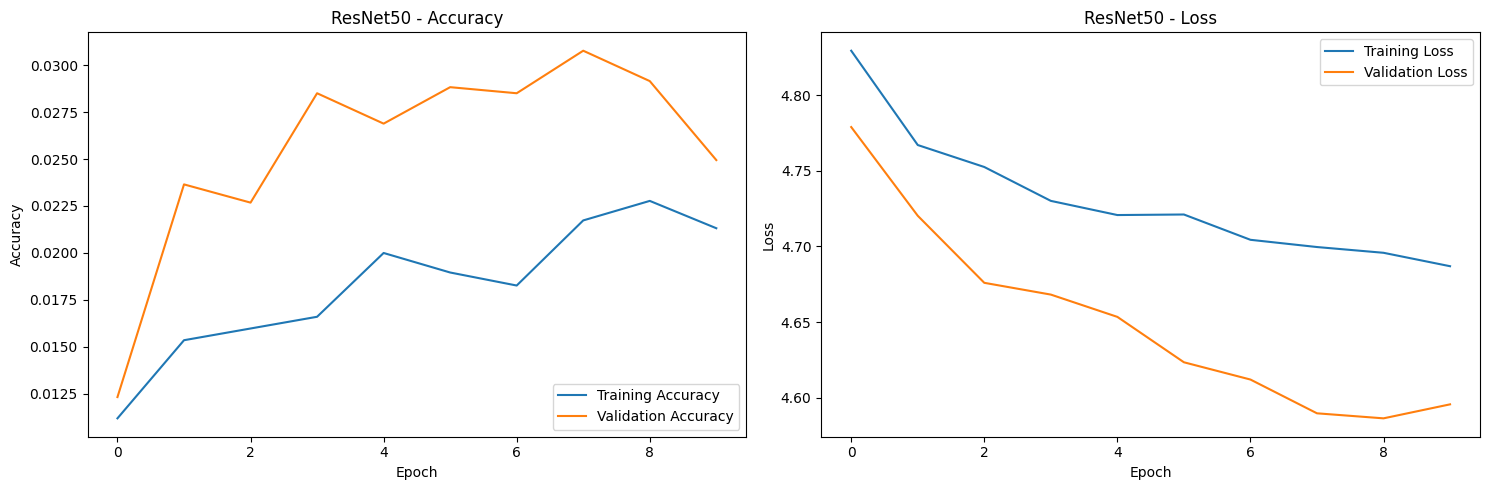

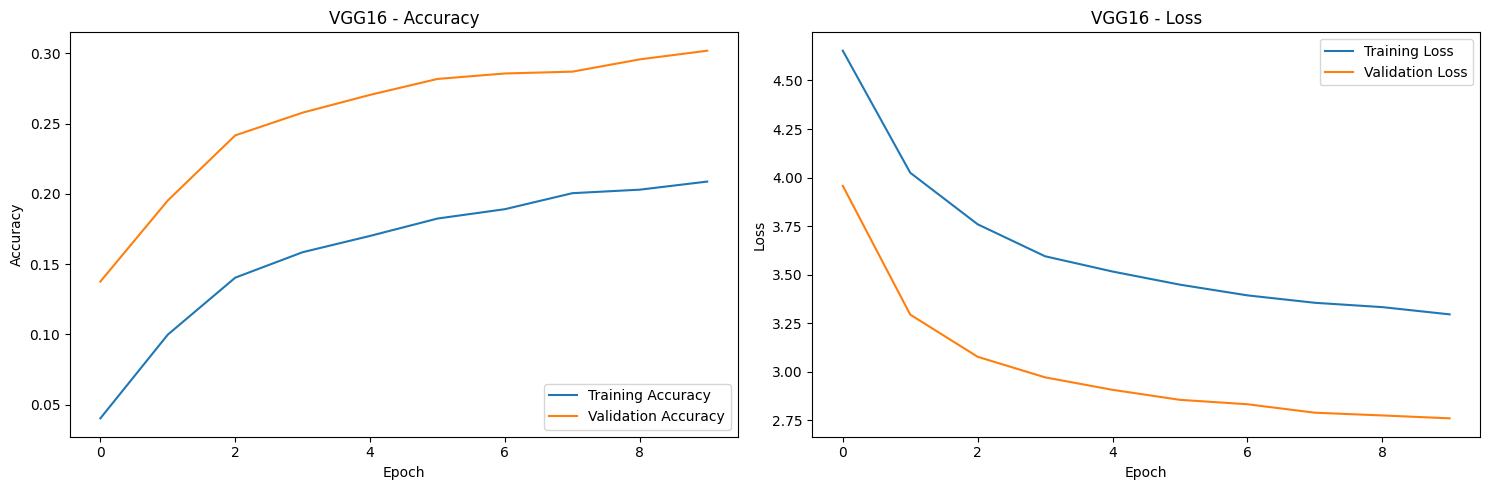

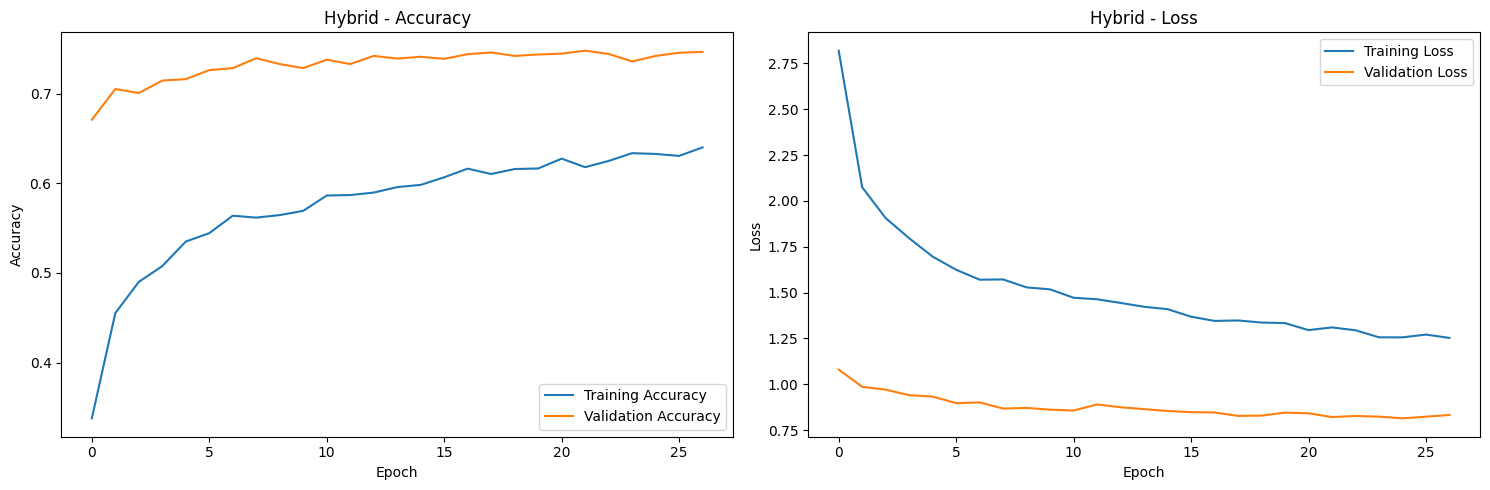

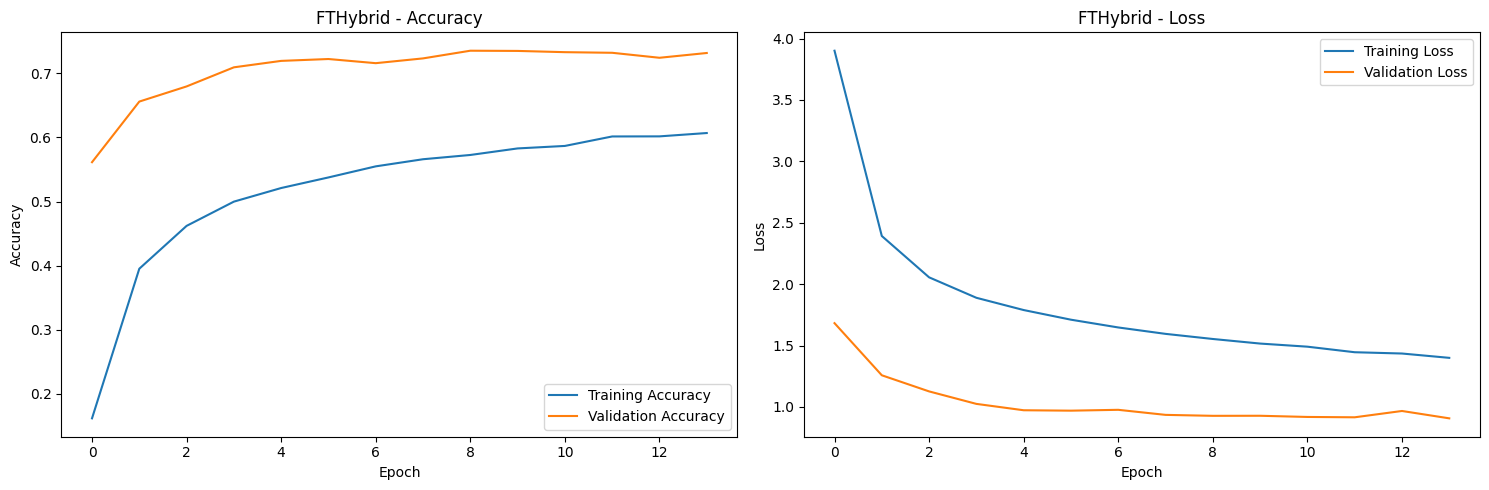

In [ ]:
plot_training_history(mobilenetv2_history, mobilenetv2_name)  # For MobileNetV2
plot_training_history(resnet50_history, resnet50_name)      # For ResNet50
plot_training_history(vgg16_history, vgg16_name)      # For ResNet50
plot_training_history(hybrid_history, hybrid_name)      # For ResNet50
plot_training_history(ft_hybrid_history, ft_hybrid_name)      # For ResNet50


In [ ]:
with open(os.path.join(metrics_dir, "fthybrid.json"), 'w') as f:
    # Convert NumPy arrays to lists for JSON serialization
    serializable_history = {
        k: [float(v) if isinstance(v, (np.floating, float, np.integer, int)) else v  # Convert numbers
            for v in (value if isinstance(value, list) else value.tolist())]  # Convert arrays
        for k, value in ft_hybrid_history.history.items()
    }
    json.dump(serializable_history, f, indent=4)